In [2]:
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import polars as pl
import numpy as np
import optuna  
from scipy.optimize import minimize
import scipy.stats as st

/Users/danielherman/Documents/projects/flickering-neon-lamp/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 5/5 [00:00<00:00, 171.90it/s]


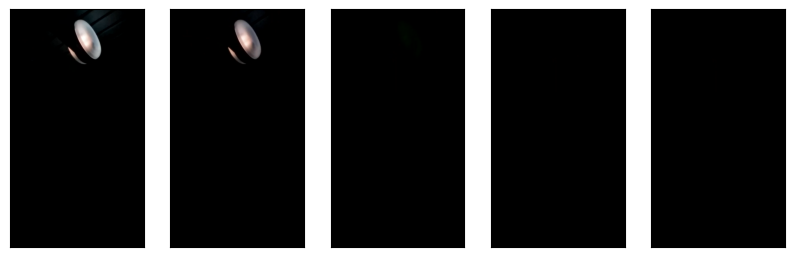

In [3]:
path = './data/frames'
files = os.listdir(path)
files.sort()
imgs = []
for i in tqdm(range(5)):
    img = cv2.imread(os.path.join(path, files[i]))
    imgs.append(img)

fig, ax = plt.subplots(1, 5, figsize=(10, 5))  
for i in range(5):
    ax[i].imshow(imgs[i])   
    ax[i].set_xticks([])  
    ax[i].set_yticks([])

plt.show()  

In [4]:
def process_image(img):
    img = img.astype('float32')
    img /= 255
    img = img.mean(axis=(0, 1, 2))
    return img

measured_states = []
for file in tqdm(files):
    img = cv2.imread(os.path.join(path, file))
    mean = process_image(img)
    img_ind = int(file.split('.')[0].split('-')[1])
    if mean > 0.002:
        new_state = 1
    else:
        new_state = 0
    measured_states.append(new_state)

100%|██████████| 6796/6796 [00:51<00:00, 130.89it/s]


100%|██████████| 6796/6796 [00:00<00:00, 5596797.56it/s]


Text(0, 0.5, 'probability')

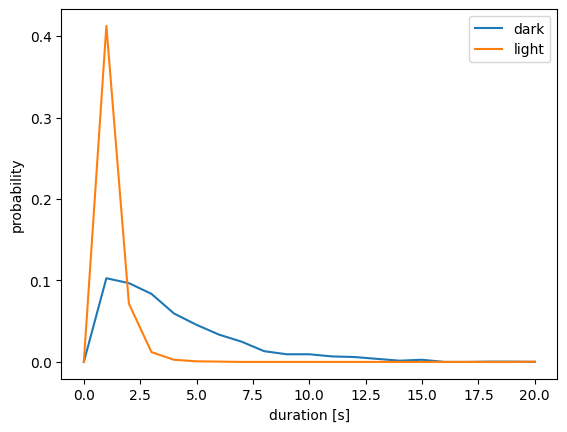

In [5]:
def process_states(measured_states):
    states_stat = []
    state = 0
    duration = 0
    for new_state in tqdm(measured_states):
        if new_state != state:
            states_stat.append((state, duration))
            duration = 0
            state = new_state

        duration += 1

    states_stat = states_stat[1:]
    max_duration = max([x[1] for x in states_stat])
    stats_counts = np.zeros((2, max_duration+1))
    for state, duration in states_stat:
        stats_counts[state, duration] += 1
    
    return stats_counts

states_stats_ref = process_states(measured_states)
states_stats_ref = states_stats_ref / states_stats_ref.sum(axis=(0, 1))
plt.plot(states_stats_ref[0], label='dark')
plt.plot(states_stats_ref[1], label='light')
plt.legend()
plt.xlabel('duration [s]')
plt.ylabel('probability')

In [6]:
def simulate_neon_lamp(params, steps=100000):
    k_dl, k_ld = params
    step_matrix = np.array([
        [1 - k_dl, k_ld],
        [k_dl, 1 - k_ld]
    ])
    state = 0
    observed_light = []
    for i in range(steps):
        state = np.random.choice([0, 1], p=step_matrix[:, state])
        if state == 1:
            observed_light.append(1)
        else:
            observed_light.append(0)

    states_stats = process_states(observed_light)
    states_stats = states_stats[:, :states_stats_ref.shape[1]]
    states_stats = states_stats / states_stats.sum(axis=(0, 1))
    return states_stats

def cost_function(params, steps=10000):
    try:
        states_stats = simulate_neon_lamp(params, steps=steps)
    except:
        return 100
    D, p = st.ks_2samp(states_stats.flatten(), states_stats_ref.flatten())
    return D

In [7]:
def objective(trial):  
    k_dl = trial.suggest_uniform('k_dl', 0, 1)  
    k_ld = trial.suggest_uniform('k_ld', 0, 1)  
    params = [k_dl, k_ld]  
    return cost_function(params, steps=10000)  
  
sampler = optuna.samplers.TPESampler(n_startup_trials=1000)  
study = optuna.create_study(sampler=sampler, direction='minimize')  
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=5000)
  
print(study.best_params)  

[I 2023-10-18 22:07:10,034] A new study created in memory with name: no-name-fe7a908e-3b4c-4a3c-939c-dd424210b81b
/var/folders/pj/m2_5zytd5p715tv2nwwfg3pc0000gp/T/ipykernel_60430/1626527618.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  k_dl = trial.suggest_uniform('k_dl', 0, 1)
/var/folders/pj/m2_5zytd5p715tv2nwwfg3pc0000gp/T/ipykernel_60430/1626527618.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  k_ld = trial.suggest_uniform('k_ld', 0, 1)
100%|██████████| 10000/10000 [00:00<00:00, 6090175.69it/s]

{'k_dl': 0.2164627755539894, 'k_ld': 0.9844101507033902}


In [9]:
k_dl, k_ld = study.best_params.values()

100%|██████████| 100000/100000 [00:00<00:00, 6836124.20it/s]


Text(0, 0.5, 'probability')

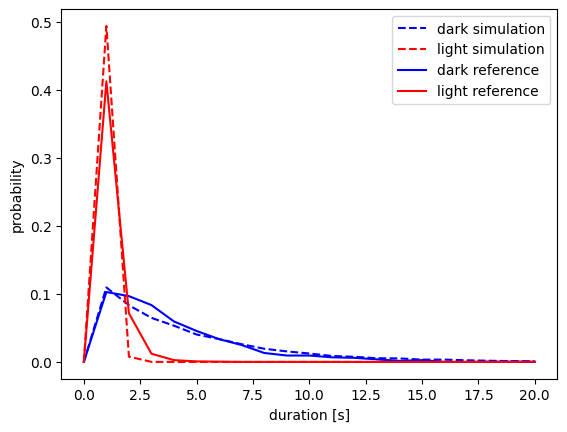

In [10]:
params = k_dl, k_ld
states_stats = simulate_neon_lamp(params, steps=100000)
vmax = max(states_stats.max(), states_stats_ref.max())

plt.plot(states_stats[0], label='dark simulation', c="b", linestyle="dashed")
plt.plot(states_stats[1], label='light simulation', c="r", linestyle="dashed")
plt.plot(states_stats_ref[0], label='dark reference', c="b", linestyle="solid")
plt.plot(states_stats_ref[1], label='light reference', c="r", linestyle="solid")
plt.legend()
plt.xlabel('duration [s]')
plt.ylabel('probability')

Text(0, 0.5, 'p_sim - p_ref')

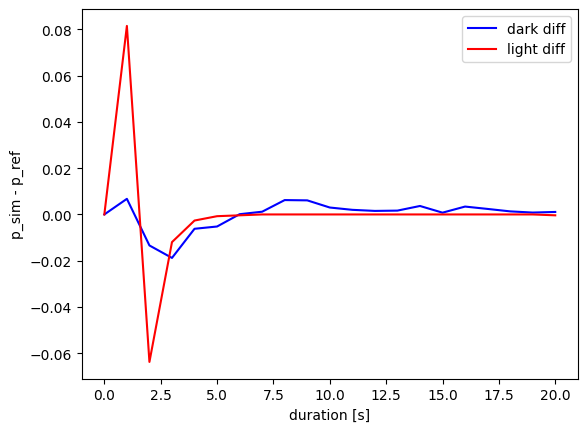

In [11]:
plt.plot(states_stats[0] - states_stats_ref[0], label='dark diff', c="b", linestyle="solid")
plt.plot(states_stats[1] - states_stats_ref[1], label='light diff', c="r", linestyle="solid")
plt.legend()
plt.xlabel('duration [s]')
plt.ylabel('p_sim - p_ref')

/var/folders/pj/m2_5zytd5p715tv2nwwfg3pc0000gp/T/ipykernel_60430/1990860430.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study) #, params=['k_dh', 'k_dl'])
[W 2023-10-18 22:19:25,958] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


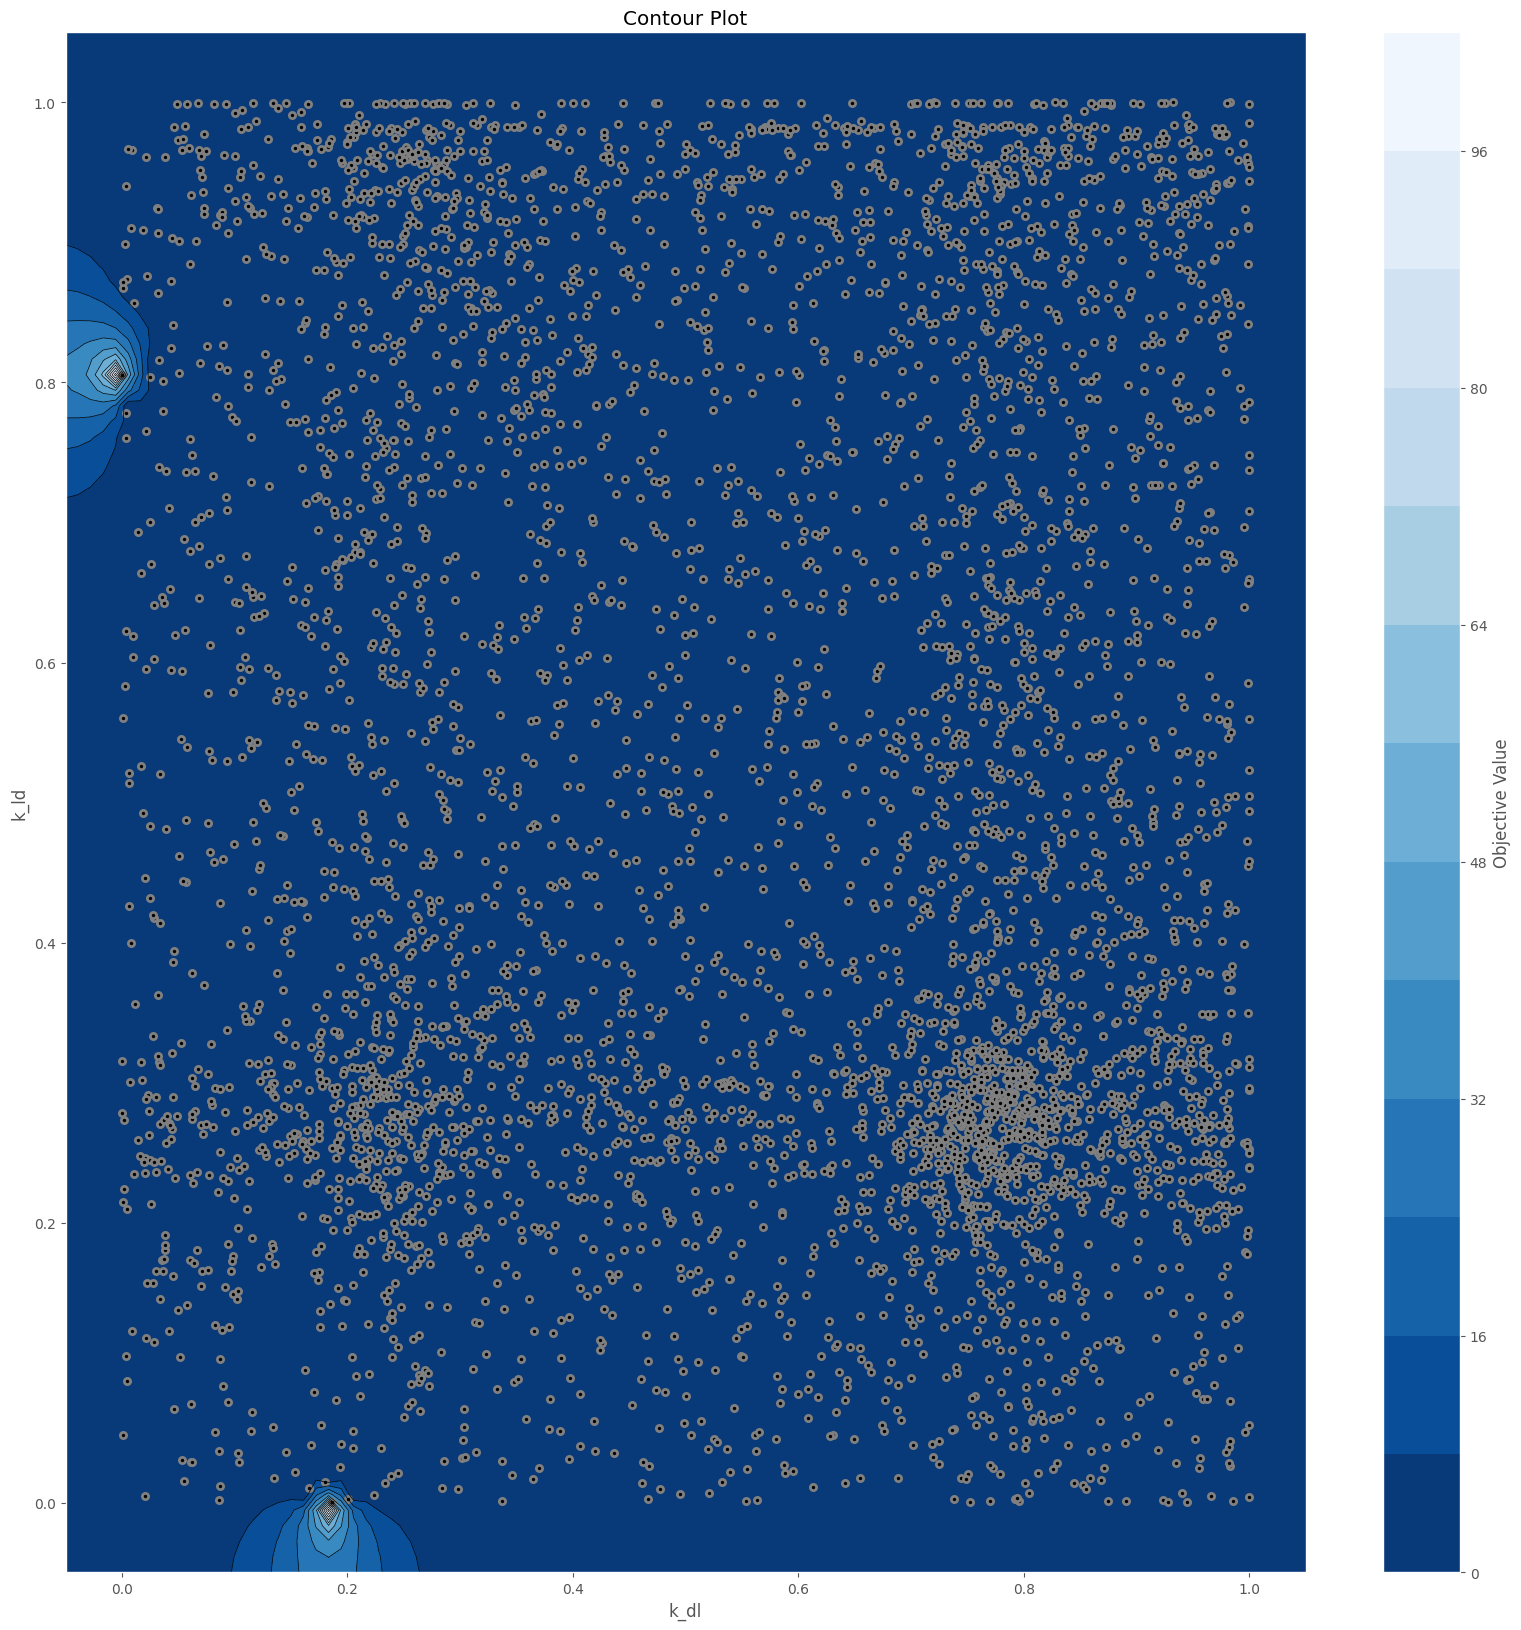

In [12]:
optuna.visualization.matplotlib.plot_contour(study) #, params=['k_dh', 'k_dl'])
fig = plt.gcf()
fig.set_size_inches(20, 20)

In [13]:
step_matrix = np.array([
        [1 - k_dl, k_ld],
        [k_dl, 1 - k_ld]
    ])

step_matrix.round(3)

array([[0.784, 0.984],
       [0.216, 0.016]])